In [566]:
import os
import pydicom
import numpy as np
import torch
import cv2
import torch
import matplotlib.pyplot as plt
import pandas as pd

def add_poisson_noise(image_tensor, noise_factor):
    """
    Adds signal-dependent Poisson noise to a PyTorch tensor and ensures the image remains non-negative.
    
    Args:
        image_tensor: A PyTorch tensor representing the image.
        noise_factor: The factor controlling the noise intensity (e.g., dose reduction).
    
    Returns:
        A noisy image tensor with Poisson noise added to the original.
    """
    # Ensure the image tensor is non-negative and shift up slightly to prevent zero values from vanishing
    min_val = image_tensor.min()
    shift_value = 1e-3 - min_val if min_val < 0 else 1e-3
    shifted_tensor = image_tensor + shift_value

    # Generate Poisson noise based on the image intensity scaled by noise factor
    noise_tensor = torch.poisson(shifted_tensor * noise_factor) / noise_factor

    # Shift back to the original scale
    final_tensor = noise_tensor - shift_value
    #torch.clamp(final_tensor, min=0, max=255) 

    #noise_tensor = torch.clamp(noise_tensor, min=0, max=255)
    return final_tensor


In [567]:
def get_cropping_coordinates(image):
    """d
    Automatically finds the cropping coordinates to remove the background areas.
    
    Args:
        image: NumPy array representing the image.
    
    Returns:
        Tuple of (x, y, w, h) coordinates for cropping.
    """
    # Normalize the image to the range [0, 255] for 8-bit conversion
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    
    # Convert the image to an 8-bit unsigned integer
    image_8bit = normalized_image.astype(np.uint8)
    
    # Convert to binary image using Otsu's thresholding
    _, thresholded = cv2.threshold(image_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour which will likely be the region of interest
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get bounding box around the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        return x, y, w, h
    else:
        # If no contours are found, return the full image dimensions
        return 0, 0, image.shape[1], image.shape[0]


In [568]:
def get_pixels_hu(slices):
    """
    Convert DICOM pixel data to Hounsfield units (HU).
    """
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        #pdb.set_trace()
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)
    return np.array(image, dtype=np.int16)

def normalize_(image, MIN_B=-32.5, MAX_B=102.5):
    """
    Normalize the image data to [0, 1] range.
    """
    image = (image - MIN_B) / (MAX_B - MIN_B)
    image = image 
    image_clip = np.clip(image,0,1)

    return image_clip 

In [569]:
def crop_image(image, x, y, w, h):
    """
    Crops the image based on the provided coordinates.
    
    Args:
        image: NumPy array representing the image.
        x, y, w, h: Cropping coordinates.
    
    Returns:
        Cropped image as a NumPy array.
    """
    return image[y:y+h, x:x+w]

In [570]:
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img

In [571]:
def load_scan(filepath):
    """
    Load DICOM slices from a file.
    """
    slices = [pydicom.dcmread(filepath, force=True)]
    return slices


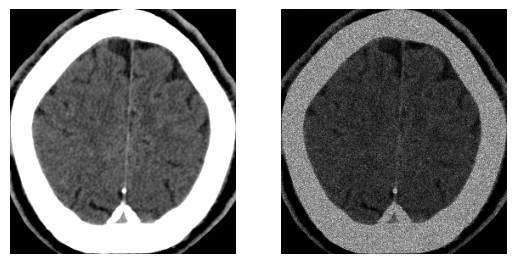

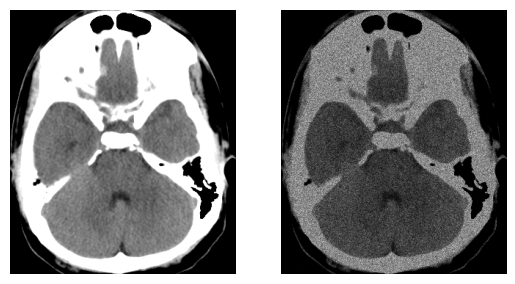

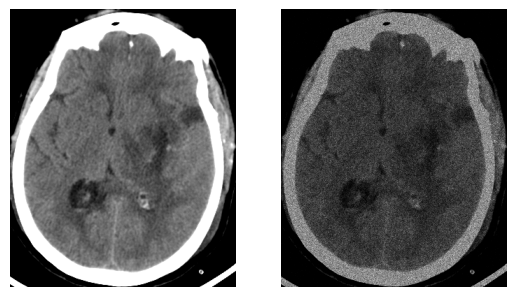

In [572]:
#def process_dicom_files(input_dir, noise_factor, sample_limit=10):
"""
Processes all DICOM files in a directory, adds Poisson noise to simulate low-dose CT,
crops the image to remove background based on full-dose image, and saves the noisy images.

Args:
    input_dir: Directory containing the original DICOM (.dcm) files.
    output_dir: Directory to save the low-dose DICOM files.
    noise_factor: The factor representing the noise scaling for the quarter-dose simulation.
"""
# Define input and output directories
import os
input_dir = 'data/Kaggle'  # Path to the directory with full-dose DICOM files
noise_factor = 30 # For low-dose simulation
sample_limit = 3  # Number of samples to process
# Initialize counter
processed_count = 0

# Iterate through all files in the input directory
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".dcm"):
            processed_count = processed_count + 1
            dicom_path = os.path.join(root, file)
            dcm = pydicom.dcmread(dicom_path)
            window_center , window_width, intercept, slope = get_windowing(dcm)
            img = dcm.pixel_array
            img = window_image(img, window_center, window_width, intercept, slope)
            
            #hu_pixels = get_pixels_hu(load_scan(dicom_path))
            #for pi in range(len(img)):
            full_dose_image = img #normalize_(img) 
            
            # Convert the full-dose image to a PyTorch tensor
            full_dose_tensor = torch.from_numpy(img)
            
            # Get cropping coordinates from the full-dose image
            x, y, w, h = get_cropping_coordinates(full_dose_image)
            
            # Crop the full-dose image based on the determined coordinates
            cropped_full_dose_image = crop_image(full_dose_image, x, y, w, h)
            
            # Simulate low-dose by adding Poisson noise to the full-dose image tensor
            low_dose_tensor = add_poisson_noise(full_dose_tensor, noise_factor)
            #low_dose_tensor =add_downsampling_noise(full_dose_tensor, noise_factor)
            
            # Convert the noisy image back to a NumPy array
            low_dose_image = low_dose_tensor.numpy()
            #low_dose_image = normalize_(low_dose_image) 
            
            # Crop the low-dose image using the same coordinates as the full-dose image
            cropped_low_dose_image = crop_image(low_dose_image, x, y, w, h)

            f_name_fdct_png = dicom_path.replace('.dcm', '_FDCT.png')
            plt.subplot(1, 2, 1)
            plt.imshow(cropped_full_dose_image, cmap='gray')
            plt.axis('off')
            #plt.savefig(f_name_fdct_png, bbox_inches='tight', pad_inches=0)

            
            f_name_ldct_png = dicom_path.replace('.dcm', '_LDCT.png')
            plt.subplot(1, 2, 2)
            plt.imshow(cropped_low_dose_image, cmap='gray')
            plt.axis('off')
            plt.show()
            #plt.savefig(cropped_low_dose_image, bbox_inches='tight', pad_inches=0)
            plt.close()
            
                
        if processed_count >= sample_limit:
            break
